# Plate reader growth rate analysis

In [1]:
using CairoMakie, resistance_evolution, CSV, DataFrames, ColorSchemes, Distributions, Makie, Turing, Polynomials, ForwardDiff
CairoMakie.activate!()

resistance_evolution.plotting_style.default_makie!()

In [2]:
color_dict = Dict(["MG1655", "3.19", "IW", "WTlac", "lacUV5"] .=> ColorSchemes.BuPu_5)
rep_dict = Dict([1, 2] .=> [:circle, :xcross])

Dict{Int64, Symbol} with 2 entries:
  2 => :xcross
  1 => :circle

In [202]:
Float64(x::ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 2}) = ForwardDiff.value(x)
Float64(x::ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 5}) = ForwardDiff.value(x)
Float64(x::ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 6}) = ForwardDiff.value(x)
Float64(x::ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 7}) = ForwardDiff.value(x)
Float64(x::ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}) = ForwardDiff.value(x)

Float64

## Import data and plot growth rates

In [4]:
files = [
    "20230207_r1_plate1",
    "20230208_r1_plate2",
    "20230302_r1_plate3",
    "20230303_r1_plate4",
    "20230308_r1_plate5",
    "20230505_r2_plate1",
    "20230509_r2_plate2",
    "20230512_r2_plate3",
    "20230519_r2_plate4",
    "20230630_r2_plate5",
]

df = DataFrame()

for file in files
    _df = CSV.read("../../processing/plate_reader/" * file * "/exp_analysis_summary.csv", DataFrame)
    insertcols!(_df, 5, :tc => map(x -> parse(Float64, split(x, "_")[1]), _df.pos_selection))
    insertcols!(_df, 5, :rep => map(x -> parse(Int64, split(x, "_")[2]), _df.strain))
    insertcols!(_df, 5, :date => parse(Int64, split(file, "_")[1]))
    _df.strain = map(x -> split(x, "_")[1], _df.strain)
    df = vcat(df, _df)
end
first(df, 5)

Row,run,strain,pos_selection,well,date,rep,tc,exp_growth_rate
,String3,SubStrin…,String15,String3,Int64,Int64,Float64,Float64
1,r1,MG1655,0.0_µg/ml_tc,A02,20230207,1,0.0,0.0109538
2,r1,MG1655,0.0_µg/ml_tc,A03,20230207,2,0.0,0.0114249
3,r1,3.19,0.0_µg/ml_tc,A04,20230207,1,0.0,0.0115151
4,r1,3.19,0.0_µg/ml_tc,A05,20230207,2,0.0,0.0115419
5,r1,IW,0.0_µg/ml_tc,A06,20230207,1,0.0,0.0118559


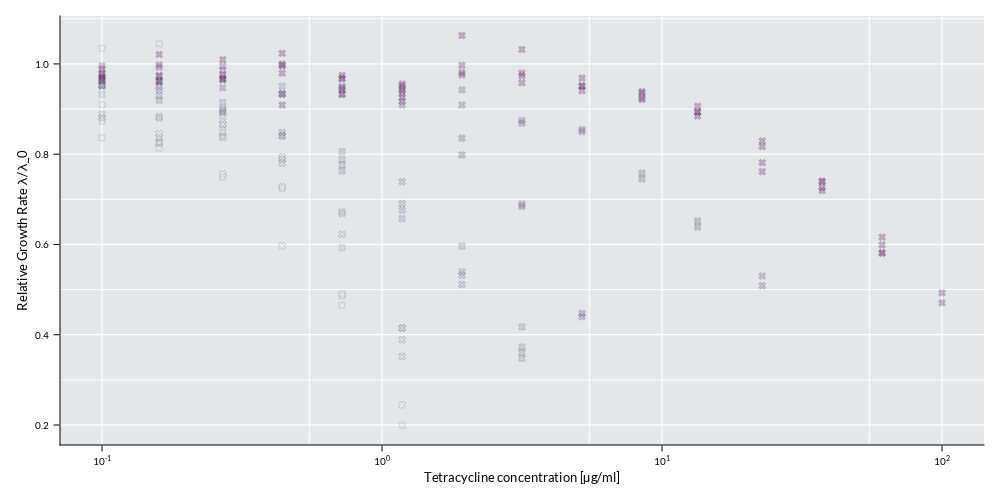

In [179]:
df.strain = map(x -> split(x, "_")[1], df.strain)

fig = Figure(resolution=(1000, 500))
ax = Axis(
    fig[1, 1], 
    xscale=log10,
    xlabelfont = "Lato",
    ylabelfont = "Lato",
    xticklabelfont = "Lato",
    yticklabelfont = "Lato"
    )

ax.ylabel = "Relative Growth Rate λ/λ_0"
ax.xlabel = "Tetracycline concentration [µg/ml]"
#ylims!(ax, 0.001, 0.0121)
#vlines!(ax, sort(unique(df.tc)), color="gray", linestyle=:dash, alpha=0.3) 
ax_list = []

for strain in df.strain |> unique
    for run in df[df.strain .== strain, "run"] |> unique
        for rep in [1, 2]
            _df = df[(df.strain .== strain) .& (df.rep .== rep) .& (df.run .== run), :]
            df_λ_0 = combine(groupby(_df[_df.tc .== 0, :], :date), :exp_growth_rate => mean)
            df_comb = combine(groupby(_df[_df.tc .> 0, :], [:tc, :date]), :exp_growth_rate => mean)
            insertcols!(df_comb,  1, :rel_growth_rate => 0.)
            for date in df_λ_0.date |> unique
                df_comb[df_comb.date .== date, :rel_growth_rate] = df_comb[df_comb.date .== date, :exp_growth_rate_mean] ./ 
                df_λ_0[df_λ_0.date .== date, :exp_growth_rate_mean]
            end
            scatter!(
                ax,
                df_comb.tc,
                df_comb[!, :rel_growth_rate],
                strokewidth=0.4,
                strokecolor=("black", 0.3),
                markersize=10,
                color=(color_dict[strain], 0.3),
                marker=:xcross
                )
        end
    end
end

marker_list = [MarkerElement(marker = marker, color = :black,
    strokecolor = :transparent,
    markersize = 8) for marker in [:circle, :xcross]]

color_list = [PolyElement(color = color) for color in ColorSchemes.BuPu_5]

#=l = Legend(fig,
    [color_list, marker_list],
    [["MG1655", "3.19", "IW", "WTlac", "lacUV5"], string.([1, 2])],
    ["Strain", "Replicate"],
    rowgap=4,
    labelfont="Lato",
    titlefont="Lato-Bold")=#

#fig[1, 2] = l


#save("tc_lambda.pdf", fig)
fig
    

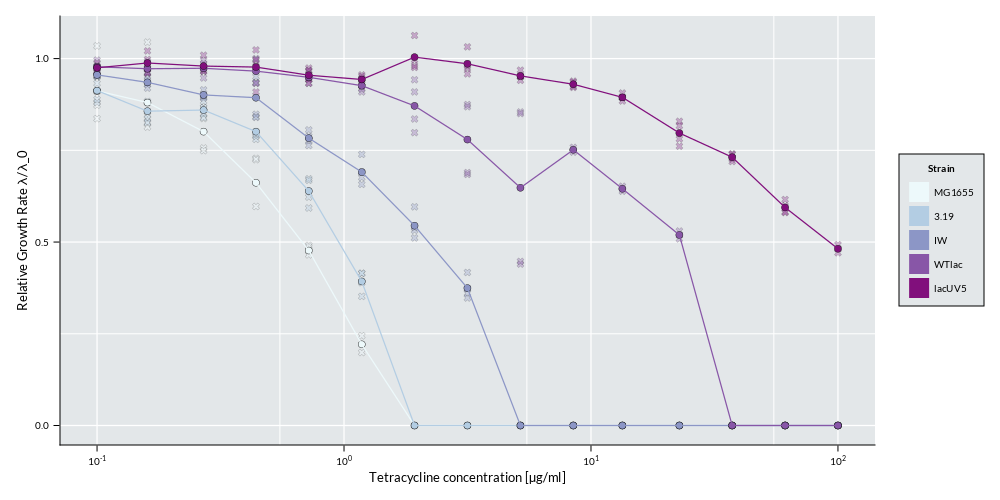

In [158]:
df.strain = map(x -> split(x, "_")[1], df.strain)

#fig = Figure(resolution=(600, 300))
#ax = Axis(fig[1, 1], xscale=log10)
##ax.ylabel = "Relative Growth Rate λ/λ_0"
#ax.xlabel = "Tetracycline concentration [µg/ml]"
#ylims!(ax, 0.001, 0.0121)
#vlines!(ax, sort(unique(df.tc)), color="gray", linestyle=:dash, alpha=0.3) 
#ax_list = []

df_λ = combine(groupby(df[df.tc .> 0, :], [:tc, :date, :strain]), :exp_growth_rate => mean => :λ)
df_λ_0 = combine(groupby(df[df.tc .== 0, :], [:strain, :date]), :exp_growth_rate => mean => :λ_0)
df_λ = innerjoin(df_λ, df_λ_0, on=[:date, :strain])

insertcols!(df_λ, 1, :rel_growth_rate => df_λ.λ ./ df_λ.λ_0)
df_λ = combine(groupby(df_λ, [:tc, :strain]), :rel_growth_rate => mean => :rel_growth_rate)
df_λ = unstack(df_λ, :tc, :rel_growth_rate)
for col in names(df_λ)
    replace!(df_λ[!, col], missing => 0)
end
df_λ = stack(df_λ, 2:16, variable_name="tc", value_name="rel_growth_rate")

for strain in df.strain |> unique
    _df = df_λ[(df_λ.strain .== strain), :]
    scatter!(
        ax,
        parse.(Float64, _df.tc),
        _df.rel_growth_rate,
        strokewidth=0.4,
        strokecolor="black",
        markersize=10,
        color=(color_dict[strain], 1),
        )
    lines!(
        ax,
        parse.(Float64, _df.tc),
        _df.rel_growth_rate,
        color=(color_dict[strain], 1),
        )
end

#marker_list = [MarkerElement(marker = marker, color = :black,
#    strokecolor = :transparent,
 #   markersize = 8) for marker in [:circle, :xcross]]

#color_list = [PolyElement(color = color) for color in ColorSchemes.BuPu_5]

l = Legend(fig,
    [color_list],
    [["MG1655", "3.19", "IW", "WTlac", "lacUV5"]],
    ["Strain"],
    rowgap=4,
    labelfont="Lato",
    titlefont="Lato-Bold")

fig[1, 2] = l




#save("tc_lambda.pdf", fig)
fig
    

## Model 

In [120]:
function p_bound(ϵ)
    return 3000/(4*10^6) * exp(-ϵ) / (1 + 3000/(4*10^6) * exp(-ϵ))
end

function solve_polynomial(aex, λ0, κt, Kd, KM, j, V0, Δr, ϵ)
    c = zeros(4)
    c1 = κt * Kd * Δr
    c[4] = c1 * (KM * λ0 - c1 + V0 * p_bound(ϵ))
    c[3] = KM * j * aex * λ0^2 - c1^2 * (j - 2λ0) - c1 * λ0 * (-KM * j  + KM * λ0 + j * aex + V0 * p_bound(ϵ))
    c[2] = c1 * λ0 * (-KM * j * λ0 + c1 * (2j - λ0) + j * aex * λ0)
    c[1] = -Kd^2*j*Δr^2*κt^2*λ0^2
    pol = Polynomial(c)
    return Polynomials.roots(pol)
end

solve_polynomial (generic function with 2 methods)

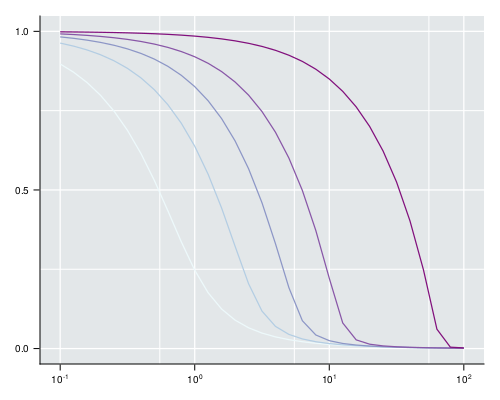

In [190]:
energy_array = [0, -3.19, -4.23,-5.19,-7.93]

j = 0.1
κt = 0.06
Kd = .03
KM = 100
Δr = 46.5
V0 = 8000

sols = Vector{Float64}[]
for ϵ in energy_array
    _sols = Float64[]
    for aex in 10 .^ collect(-1:0.1:2)
        if ϵ == 0
            solutions = solve_polynomial(aex, 0.69, κt, Kd, KM, j, 0, Δr, ϵ)
        else
            solutions = solve_polynomial(aex, 0.69, κt, Kd, KM, j, V0, Δr, ϵ)
        end
        y = [imag(x) == 0 ? real(x)/0.69 : missing for x in solutions]
        y = filter(x -> !ismissing(x) && (x > 0), y)
        push!(_sols, y[1])
    end
    push!(sols, _sols)
end
fig = Figure(resolution=(500, 400))
ax = Axis(fig[1, 1], xscale=log10)

for (i, strain) in enumerate(["MG1655", "3.19", "IW", "WTlac", "lacUV5"])
    lines!(ax, 10 .^ collect(-1:0.1:2), sols[i], color=(color_dict[strain], 1))
end

fig

In [191]:
@model function fit_growth_syn(growth_rates, aex_arr, aex_ppc, energy_array)
    
    y_ppc = zeros(Float64, 5, length(aex_ppc))
    # Priors
    log_j ~ Normal(-1, 2)
    log_sigma ~ Normal(-3, 1)
    log_κt ~ Normal(-2, 1)
    log_KM ~ Normal(1, 0.5)
    log_Kd ~ Normal(-1, 0.5)
    log_Δr ~ Normal(1.5, 0.25)
    log_V0 ~ Normal(2, 3)
    
    # Transform Parameters
    sigma = float(10^log_sigma)
    j = 10^log_j
    κt = 10^log_κt
    KM = 10^log_KM
    V0 = 10^log_V0
    Δr = 10^log_Δr
    Kd = 10^log_Kd
    
    # Fixed Parameters
    λ0_0 = growth_rates[1][1] * 60 
    λ0_1 = growth_rates[2][1] * 60 
    λ0_2 = growth_rates[3][1] * 60 
    λ0_3 = growth_rates[4][1] * 60 
    λ0_4 = growth_rates[5][1] * 60 
    
    for (i, aex) in enumerate(aex_arr)
        for (k, (λ0 ,ϵ)) in enumerate(zip([λ0_0, λ0_1, λ0_2, λ0_3, λ0_4], energy_array)) 
            if k == 1
                x = [aex, λ0, κt, Kd, KM, j, 0, Δr, ϵ]
            else
                x = [aex, λ0, κt, Kd, KM, j, V0, Δr, ϵ]
            end

        
            solutions = solve_polynomial(x...)
            y = [imag(x) == 0 ? real(x)/λ0 : missing for x in solutions]
            y = filter(x -> !ismissing(x) && (x > 0), y)
            
            if length(y) == 3
                deleteat!(y, 2)
                opt_y = y[argmin([(growth_rates[k][i] - root)^2 for root in y])]
            else
                opt_y = y[1]
            end
            growth_rates[k][i] ~ Normal(opt_y, sigma)
        end
    end
    for (i, aex) in enumerate(aex_ppc)
        for (k, (λ0 ,ϵ)) in enumerate(zip([λ0_0, λ0_1, λ0_2, λ0_3, λ0_4], energy_array))
            if k == 1
                x = [aex, λ0, κt, Kd, KM, j, 0, Δr, ϵ]
            else
                x = [aex, λ0, κt, Kd, KM, j, V0, Δr, ϵ]
            end
            solutions = solve_polynomial(x...)
            y = [imag(x) == 0 ? real(x)/λ0 : missing for x in solutions]
            y = filter(x -> !ismissing(x) && (x > 0), y)
            
            if length(y) == 3
                deleteat!(y, 2)
                opt_y = y[argmin([(growth_rates[k][i] - root)^2 for root in y])]
            else
                opt_y = y[1]
            end
            y_ppc[k, i] = rand(Normal(opt_y, sigma), 1)[1]
        end
    end
    return V0, KM, Kd, κt, Δr, j, sigma, y_ppc
end

fit_growth_syn (generic function with 4 methods)

In [192]:
x = parse.(Float64, df_λ[df_λ.strain .== "MG1655", :tc])
y = df_λ[df_λ.strain .== "MG1655", :rel_growth_rate]

15-element Vector{Union{Missing, Float64}}:
 0.91204984957875
 0.8801927660983047
 0.8009471558431253
 0.6616500792750333
 0.47692050412184445
 0.22119540407014623
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [193]:
y = [convert(Vector{Float64}, df_λ[df_λ.strain .== x, :rel_growth_rate]) for x in unique(df_λ.strain)];

In [214]:
chn = sample(fit_growth_syn(y, x, x, energy_array), NUTS(0.65), 50000)
chains_params = Turing.MCMCChains.get_sections(chn, :parameters)
gen = generated_quantities(fit_growth_syn(y, x, x, energy_array), chains_params);

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 1 days, 0:46:54


LoadError: InterruptException:

In [215]:
length(gen[1][2])

1

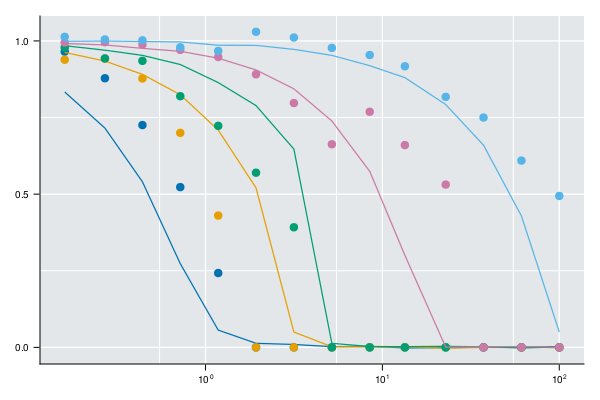

In [216]:
y_ppc = sum([x[end] for x in gen]) / length(gen)

λ_0_infer = hcat([x[1] for x in gen]...) |> mean

fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
for i in 1:5
    scatter!(ax, x[2:end], y[i][2:end] ./ y[i][1])
    lines!(ax, x[2:end], y_ppc[i, 2:end])
end


fig

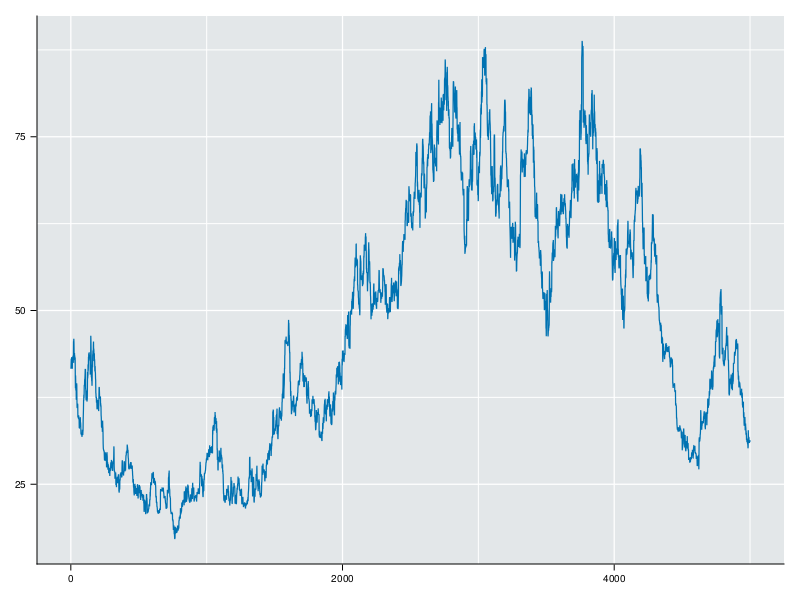

In [217]:
V0 = [x[5] for x in gen] |> vec
lines(V0)

In [133]:
κt = 0.06
Kd = .1
KM = 10
Δr = 46.5
j = 0.16

fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
for (i, ϵ) in enumerate(energy_array)
    _y = [solve_polynomial(_x, y[i][1] * 60, κt, Kd, KM, j, 1000, Δr, ϵ)[3] for _x in x ]
    println(_y)
    #scatter!(ax, x[2:end], y[i][2:end] ./ y[i][1])
    lines!(ax, x[2:end], _y[2:end]./ (y[i][1] * 60))
    println(y[i][1])
end
fig

[51.59872142326226, 49.72474105980252, 46.290447611257925, 40.98718046385177, 32.2697582199912, 18.066588929037287, 1.223421341660385, 0.1957205995644394, 0.08105383742484494, 0.04138703604593691, 0.023925889335054126, 0.013247233122757898, 0.007845657244599086, 0.0047000434082977325, 0.0028393704539150843]
0.91204984957875
[51.73758460507349, 49.91860559274455, 46.585011403317246, 41.43690270780763, 32.972871629937174, 19.166145264822124, 1.5084502810683293, 0.20248316403419447, 0.0820226110000205, 0.04158844591315439, 0.02397775171183369, 0.013258301525725578, 0.007848302309443746, 0.004700666848832608, 0.0028395162521983736]
0.9128348500509185
[54.31489217638669, 52.502768449856326, 49.18155067014622, 44.051922017234794, 35.61542273921443, 21.829534741406246, 2.3197759205991146, 0.2152536757836943, 0.08373401845587836, 0.041936465408551386, 0.02406660098683178, 0.013277203867712136, 0.007852824864277758, 0.00470173774005248, 0.002839768874142344]
0.9555973270976771
[55.8633233493369

LoadError: `Makie.convert_arguments` for the plot type Lines{Tuple{Vector{Float64}, Vector{Number}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Vector{Number}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.
